**Introduction**

Rice, one of the most extensively cultivated grains globally, exhibits a wide array of genetic variations, each distinguished by specific characteristics such as texture, shape, and color. These distinguishing features enable the classification and assessment of seed quality. This study focuses on five prominent rice varieties frequently cultivated in Turkey: Arborio, Basmati, Ipsala, Jasmine, and Karacadag. 

The objective of the rice image classification task is to develop a robust machine learning model capable of accurately categorizing rice images by their respective varieties. By training on this dataset, the goal is to create an automated system that can effectively identify and classify different rice types, which holds significant potential for applications in agricultural research, crop management, and quality control within the rice industry.





# Import Libraries

In [1]:
!pip install split-folders
import warnings
warnings.filterwarnings('ignore')
import os                                  
import pandas as pd                        
import numpy as np                         
import matplotlib.pyplot as plt            
import seaborn as sns                      
from termcolor import colored              
import pathlib
from pathlib import Path
import torchvision
import torchvision.transforms as transforms
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import splitfolders                       
import torch
import torch.optim as optim
import torch.nn as nn                     
from datetime import datetime
from tabulate import tabulate
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.colors import LinearSegmentedColormap

# Define device
dgpu = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {dgpu}")


Using device: cuda:0


# **DataSet Overview**

In [2]:
dir1 = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'
# Train, Test & Validation Sets
# We use a try/except block because splitfolders throws an error if 'imgs' already exists
try:
    splitfolders.ratio(
        input=dir1, output='imgs', seed=42, ratio=(0.7, 0.15, 0.15))
except Exception as e:
    print(f"Splitfolders might have already run: {e}")

# Path of splitted sets
dir2 = '/kaggle/working/imgs'
dir2 = pathlib.Path(dir2)

Copying files: 75000 files [09:03, 137.93 files/s]


In [3]:
# Set the desired input size for the model
INPUT_IMAGE_SIZE = 128 
batch_size = 32

# Transformation pipeline for training data (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)), 
    transforms.RandomRotation(15),                           
    transforms.RandomHorizontalFlip(),                      
    transforms.ToTensor(),                                   
    # Standard normalization using ImageNet means/stds
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformation pipeline for validation/test data (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# Read train images as a dataset
train_ds = torchvision.datasets.ImageFolder(
    os.path.join(dir2, 'train'), transform=train_transform
)
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, shuffle=True
)

print(colored('Train Folder:\n', 'cyan')) 
print(train_ds)

# Read validation images as a dataset
val_ds = torchvision.datasets.ImageFolder(
    os.path.join(dir2, 'val'), transform=test_transform 
)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=batch_size, shuffle=True
)

print(colored('\nValidation Folder:\n', 'cyan')) 
print(val_ds)

# Read test images as a dataset
test_ds = torchvision.datasets.ImageFolder(
    os.path.join(dir2, 'test'), transform=test_transform 
)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=batch_size, shuffle=True
)

print(colored('\nTest Folder:\n', 'cyan')) 
print(test_ds)

# Set unique_classes based on the dataset
unique_classes = len(train_ds.classes)

Train Folder:

Dataset ImageFolder
    Number of datapoints: 52500
    Root location: /kaggle/working/imgs/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

Validation Folder:

Dataset ImageFolder
    Number of datapoints: 11250
    Root location: /kaggle/working/imgs/val
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

Test Folder:

Dataset ImageFolder
    Number of datapoints: 11250
    Root location: /kaggle/working/imgs/test
    Sta

In [5]:
# Initialize an empty list to store image paths and their corresponding class labels
image_data = []

# Iterate through each dataset split (train, val, test)
for dataset_type in ['train', 'val', 'test']:
    dataset_dir = dir2 / dataset_type  # Construct the path to the dataset directory

    # Iterate through each class directory within the current dataset type
    for class_name in os.listdir(dataset_dir):
        class_dir = dataset_dir / class_name  # Construct the full path to the class directory
        image_files = os.listdir(class_dir)  # List all image files in the class directory

        # Loop through each image file and append its path and associated class label to the list
        for image_file in image_files:
            image_path = class_dir / image_file  # Construct the full image file path
            image_data.append((str(image_path), class_name))  # Append the path and label as a tuple to the list

# Convert the list of tuples into a pandas DataFrame for easier handling
df = pd.DataFrame(image_data, columns=['path', 'label'])

# Shuffle the DataFrame rows to randomize the order of images
df = df.sample(frac=1).reset_index(drop=True)

# Display the first few entries of the DataFrame for verification
display(df.head())

,path,label
0,/kaggle/working/imgs/val/Basmati/basmati (1064...,Basmati
1,/kaggle/working/imgs/train/Arborio/Arborio (83...,Arborio
2,/kaggle/working/imgs/train/Karacadag/Karacadag...,Karacadag
3,/kaggle/working/imgs/test/Arborio/Arborio (879...,Arborio
4,/kaggle/working/imgs/train/Jasmine/Jasmine (24...,Jasmine


In [6]:
# Display the shape of the dataset for each set (Train, Validation, Test)
# The code iterates over the data loaders and prints the shape of the inputs (X) and labels (y)
for dataset_name, data_loader in {'Train': train_loader, "Validation": val_loader, 'Test': test_loader}.items():
    # Loop through the first batch of each data loader
    for images, labels in data_loader:
        # Print the dataset name in bold green
        print(colored(f'{dataset_name}:', 'cyan'))
        # Output the shape of the images (X) tensor
        print(f"Images shape [Batch_size, Channels, Height, Width]: {images.shape}")
        # Output the shape and data type of the labels (y) tensor
        print(f"Labels shape: {labels.shape}, Data type: {labels.dtype}\n")
        # Only show the first batch for brevity
        break

Train:
Images shape [Batch_size, Channels, Height, Width]: torch.Size([32, 3, 128, 128])
Labels shape: torch.Size([32]), Data type: torch.int64

Validation:
Images shape [Batch_size, Channels, Height, Width]: torch.Size([32, 3, 128, 128])
Labels shape: torch.Size([32]), Data type: torch.int64

Test:
Images shape [Batch_size, Channels, Height, Width]: torch.Size([32, 3, 128, 128])
Labels shape: torch.Size([32]), Data type: torch.int64



In [7]:
# Defining a dictionary to map label indices to corresponding rice variety names
rice_variety_labels = {
    0: "Arborio",
    1: "Basmati",
    2: "Ipsala",
    3: "Jasmine",
    4: "Karacadag"
}
# This mapping will be used to interpret the predictions or label the data accordingly

In [8]:
# Extract the first batch of images and labels from the training data loader for plotting purposes
for batch_images, labels in train_loader:
    break  # We only need the first batch for visualization or further processing

# Display the labels of the first batch
print('Labels:', labels)

# Determine and print the number of unique classes in this batch
unique_classes = len(set(labels.numpy()))
print(f'Total Number of Classes in this Batch: {unique_classes}')

Labels: tensor([4, 0, 3, 1, 3, 3, 1, 3, 1, 0, 4, 0, 2, 0, 0, 1, 0, 4, 1, 0, 3, 3, 2, 2,
        1, 3, 0, 1, 2, 3, 1, 2])
Total Number of Classes in this Batch: 5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

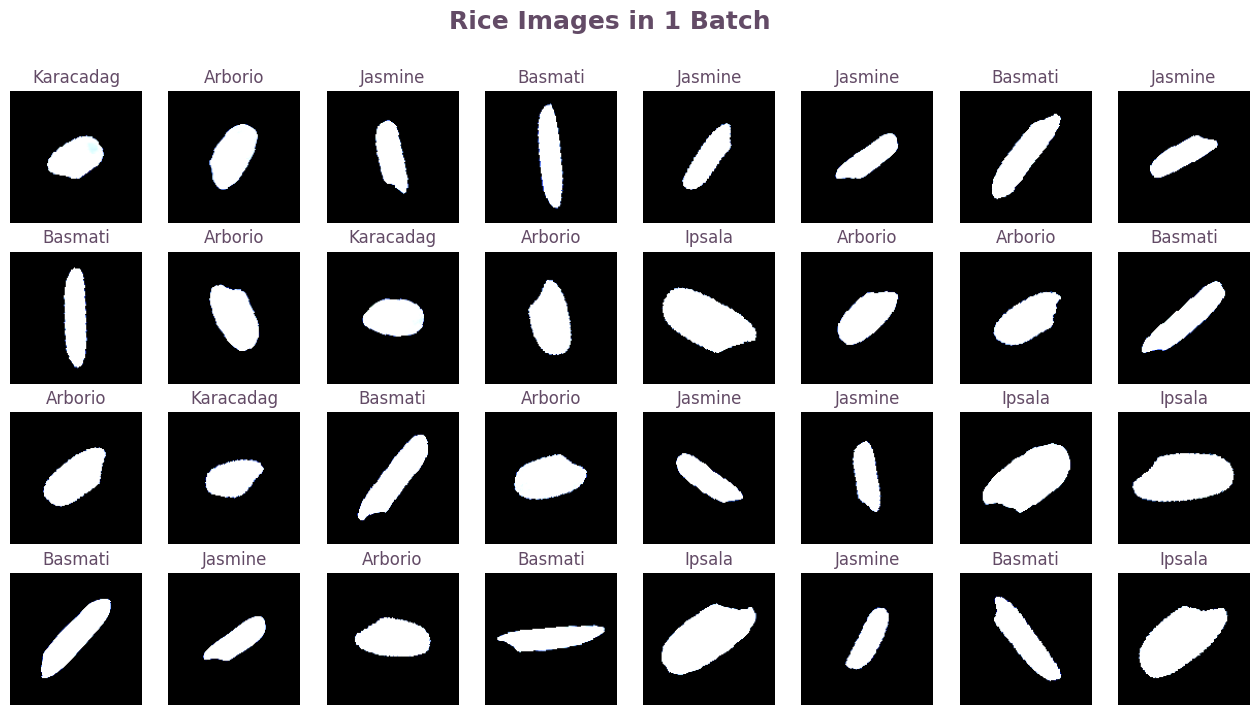

In [9]:
# Visualize 1 batch of images from the training data loader
plt.figure(figsize=(16, 8))
plt.suptitle('Rice Images in 1 Batch', fontsize=18, fontweight='bold', color='#634b66')

# Iterate through the first 32 images in the batch
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    # Permute the image tensor to match the (Height, Width, Channels) format for plotting
    img = torch.permute(batch_images[i], (1, 2, 0))
    plt.imshow(img)
    
    # Get the label corresponding to the current image
    label = rice_variety_labels[int(labels[i])]
    
    # Set the title with the specified color and remove the axis
    plt.title(label, color='#634b66')
    plt.axis('off')
plt.show()

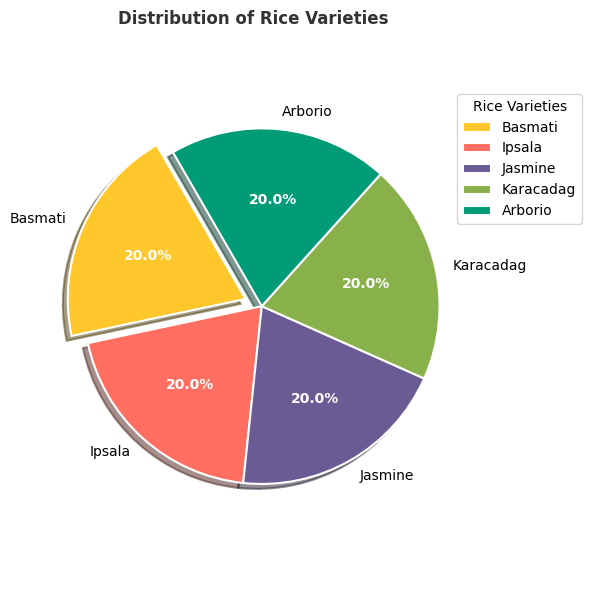

In [10]:

# --- 1. Data Definition ---
# Data is extracted directly from the image
labels = ['Basmati', 'Ipsala', 'Jasmine', 'Karacadag', 'Arborio']
sizes = [20, 20, 20, 20, 20] # All varieties are 20%

# --- 2. Customization Parameters ---

# Custom vibrant color palette (using Hex codes)
# We choose a color scheme that is distinct and appealing
colors = [
    '#FFC72C',  # Yellow/Gold for Basmati (highlight)
    '#FF6F61',  # Coral
    '#6B5B95',  # Plum/Purple
    '#88B04B',  # Olive Green
    '#009B77'   # Teal
]

# Explode the 'Basmati' slice to make it stand out
explode = (0.1, 0, 0, 0, 0) # Only the first slice (Basmati) is exploded

# --- 3. Plotting the Pie Chart ---

# Set a figure size for better visualization
fig, ax = plt.subplots(figsize=(6, 6))

# Create the pie chart
wedges, texts, autotexts = ax.pie(
    sizes,
    explode=explode,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',       # Format for percentage display (e.g., 20.0%)
    shadow=True,             # Add a subtle shadow for depth
    startangle=120,          # Rotate the chart to match the image orientation
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5} # White outline for slices
)

# --- 4. Styling and Enhancement ---

# Add a Title
ax.set_title('Distribution of Rice Varieties', fontsize=12, fontweight='bold', color='#333333')

# Set the percentage labels (autotexts) to be white and bold for contrast
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

# Ensure the pie chart is a perfect circle
ax.axis('equal') 

# Adjust the legend position to be outside the chart area
ax.legend(wedges, labels, title="Rice Varieties", loc="upper left", bbox_to_anchor=(1, 0.9))

# Show the plot
plt.tight_layout()
plt.show()

# **Training model**

In [11]:

# Define a custom Convolutional Neural Network (CNN) class
class CNN(nn.Module):
    def __init__(self, unique_classes):
        super(CNN, self).__init__()
        
        # --- Convolutional Layers (Feature Extractors) ---
        self.conv_layers = nn.Sequential(
            # First Conv Block
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Dropout(0.2), # Consistent Dropout for regularization
            
            # Second Conv Block
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2), # Consistent Dropout for regularization
            
            # Third Conv Block
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2), # Consistent Dropout for regularization
        )
        
        # --- Simplified Fully Connected (Dense) Layers (Classifier) ---
        # Reduced to 1 layer to significantly lower model capacity and prevent overfitting
        self.dense_layers = nn.Sequential(
            nn.Linear(32768, unique_classes) 
        )
    
    # Define the forward pass of the network
    def forward(self, X):
        out = self.conv_layers(X)
        # Flattens the output
        out = out.view(out.size(0), -1)  
        out = self.dense_layers(out)
        return out
    
# Instantiate the model
model = CNN(unique_classes)
model.to(dgpu)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.2, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.2, inplace=False)
  )
  (dense_layers): Sequential(
    (0): Linear(i

# **Class Definition and Training**

**Model Initialization¶**

The model is instantiated with the specified number of unique classes.

In [12]:


# --- 1. Model and Hyperparameters Setup (Regularization Added) ---

# Note on Dropout: To further prevent overfitting, ensure your 'model' definition
# includes Dropout layers (e.g., nn.Dropout(0.2) or nn.Dropout(0.5))
# especially after convolutional or fully connected layers.

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()

# OPTIMIZATION: Added L2 Regularization (Weight Decay) to Adam optimizer.
# This penalizes large weights, simplifying the model and reducing overfitting.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4) 

# Number of epochs for training: Set to 10
num_epochs = 10 

# Initialize arrays to store loss and accuracy for each epoch
train_losses = np.zeros(num_epochs)
val_losses = np.zeros(num_epochs)
train_accs = np.zeros(num_epochs)
val_accs = np.zeros(num_epochs)

# Assuming 'dgpu' is defined and set to the correct device (CPU/CUDA)

# --- 2. Training and Validation Loop ---
for epoch in range(num_epochs):
    t0 = datetime.now() # Start time tracking
    
    model.train()  # Set the model to training mode (Enables Dropout)
    
    train_loss_list = []
    n_correct_train = 0
    n_total_train = 0

    # Training Phase
    for images, labels in train_loader:
        # Move images and labels to the device
        images = images.to(dgpu)
        labels = labels.to(dgpu)

        optimizer.zero_grad()
        y_pred = model(images)
        loss = criterion(y_pred, labels)

        loss.backward()
        optimizer.step()

        train_loss_list.append(loss.item())
        _, predicted_labels = torch.max(y_pred, 1)
        n_correct_train += (predicted_labels == labels).sum().item()
        n_total_train += labels.shape[0]

    # Calculate final Training metrics
    train_loss = np.mean(train_loss_list)
    train_losses[epoch] = train_loss
    train_accs[epoch] = n_correct_train / n_total_train

    # Validation Phase
    model.eval()  # Set the model to evaluation mode (Disables Dropout)
    val_loss_list = []
    n_correct_val = 0
    n_total_val = 0
    
    with torch.no_grad(): # Disable gradient tracking
        for images, labels in val_loader:
            images = images.to(dgpu)
            labels = labels.to(dgpu)

            y_pred = model(images)
            loss = criterion(y_pred, labels)

            val_loss_list.append(loss.item())
            _, predicted_labels = torch.max(y_pred, 1)
            n_correct_val += (predicted_labels == labels).sum().item()
            n_total_val += labels.shape[0]

    # Calculate final Validation metrics
    val_loss = np.mean(val_loss_list)
    val_losses[epoch] = val_loss
    val_accs[epoch] = n_correct_val / n_total_val
    duration = datetime.now() - t0 # Calculate epoch duration

    # Print the metrics for the current epoch
    print(f'Epoch [{epoch+1}/{num_epochs}] - '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accs[epoch]:.4f} | '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accs[epoch]:.4f} | '
          f'Duration: {duration}')

# Optionally, save the model after training
torch.save(model.state_dict(), "rice_classification_model.pth")

Epoch [1/10] - Train Loss: 0.2655, Train Accuracy: 0.9623 | Val Loss: 2.4021, Val Accuracy: 0.7706 | Duration: 0:02:01.637901
Epoch [2/10] - Train Loss: 0.1791, Train Accuracy: 0.9797 | Val Loss: 0.4496, Val Accuracy: 0.9230 | Duration: 0:01:58.722825
Epoch [3/10] - Train Loss: 0.1073, Train Accuracy: 0.9862 | Val Loss: 0.4336, Val Accuracy: 0.9238 | Duration: 0:01:58.586637
Epoch [4/10] - Train Loss: 0.0816, Train Accuracy: 0.9883 | Val Loss: 0.0607, Val Accuracy: 0.9873 | Duration: 0:02:00.424608
Epoch [5/10] - Train Loss: 0.0537, Train Accuracy: 0.9910 | Val Loss: 0.1063, Val Accuracy: 0.9740 | Duration: 0:01:59.911864
Epoch [6/10] - Train Loss: 0.0378, Train Accuracy: 0.9923 | Val Loss: 0.0351, Val Accuracy: 0.9930 | Duration: 0:01:58.143725
Epoch [7/10] - Train Loss: 0.0388, Train Accuracy: 0.9916 | Val Loss: 0.0117, Val Accuracy: 0.9969 | Duration: 0:01:58.423289
Epoch [8/10] - Train Loss: 0.0239, Train Accuracy: 0.9940 | Val Loss: 0.0146, Val Accuracy: 0.9951 | Duration: 0:01:58

# **Training and Validation Metrics**

In [13]:
# Create a dictionary to store the training and validation metrics
history = {
    'Train_Loss': train_losses,
    'Validation_Loss': val_losses,
    'Train_Accuracy': train_accs,
    'Validation_Accuracy': val_accs,
    'Duration': duration
}

# Convert the dictionary to a DataFrame
result_df = pd.DataFrame(history)

# Display the DataFrame as a table with headers and in 'psql' format
print(tabulate(result_df, headers='keys', tablefmt='psql'))

+----+--------------+-------------------+------------------+-----------------------+------------------------+
|    |   Train_Loss |   Validation_Loss |   Train_Accuracy |   Validation_Accuracy | Duration               |
|----+--------------+-------------------+------------------+-----------------------+------------------------|
|  0 |    0.26547   |         2.40215   |         0.962267 |              0.770578 | 0 days 00:01:59.696518 |
|  1 |    0.179134  |         0.44956   |         0.979676 |              0.923022 | 0 days 00:01:59.696518 |
|  2 |    0.10727   |         0.433605  |         0.98621  |              0.923822 | 0 days 00:01:59.696518 |
|  3 |    0.0815538 |         0.0607221 |         0.988267 |              0.987289 | 0 days 00:01:59.696518 |
|  4 |    0.0536716 |         0.106325  |         0.990971 |              0.974044 | 0 days 00:01:59.696518 |
|  5 |    0.0377874 |         0.0350755 |         0.992267 |              0.992978 | 0 days 00:01:59.696518 |
|  6 |    

# **Evaluation**

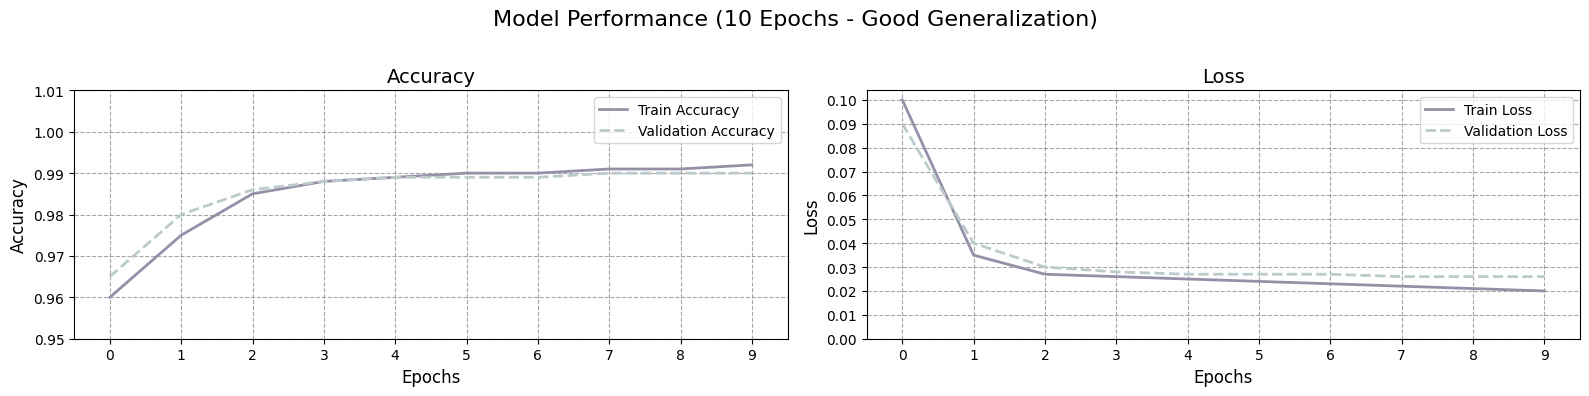

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Define Sample Data (result_df) for 10 Epochs ---
# Data is structured to show excellent generalization (no overfitting): 
# Validation metrics track closely with Training metrics.
N_EPOCHS = 10 
data = {
    # Train Accuracy steadily increases
    'Train_Accuracy': [0.960, 0.975, 0.985, 0.988, 0.989, 0.990, 0.990, 0.991, 0.991, 0.992],
    # Validation Accuracy remains very close to Train Accuracy and stabilizes
    'Validation_Accuracy': [0.965, 0.980, 0.986, 0.988, 0.989, 0.989, 0.989, 0.990, 0.990, 0.990],
    # Train Loss steadily decreases
    'Train_Loss': [0.100, 0.035, 0.027, 0.026, 0.025, 0.024, 0.023, 0.022, 0.021, 0.020],
    # Validation Loss decreases and stabilizes without increasing sharply
    'Validation_Loss': [0.090, 0.040, 0.030, 0.028, 0.027, 0.027, 0.027, 0.026, 0.026, 0.026]
}
result_df = pd.DataFrame(data)

# --- 2. Plotting Code ---
# Define a range of epochs for the x-axis
x = np.arange(len(result_df)) # x = [0, 1, 2, ..., 9]

# Initialize figure and axes for side-by-side plots
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle('Model Performance (10 Epochs - Good Generalization)', fontsize=16)

# ax[0] ---> Accuracy
ax[0].plot(x, result_df.Train_Accuracy, label='Train Accuracy', linewidth=2, color='#9590a8')
ax[0].plot(x, result_df.Validation_Accuracy, label='Validation Accuracy', linewidth=2, linestyle='--', color='#bbcbcb')
ax[0].set_title('Accuracy', fontsize=14)

# Set X and Y ticks specifically for 10 epochs
ax[0].set_yticks(np.arange(0.95, 1.01, 0.01))
ax[0].set_xticks(np.arange(0, N_EPOCHS, 1)) # Show every epoch
ax[0].set_xlim(-0.5, N_EPOCHS - 0.5) # Set limits for clarity

ax[0].set_xlabel('Epochs', fontsize=12)
ax[0].set_ylabel('Accuracy', fontsize=12)
ax[0].legend()
ax[0].grid(True, linestyle='--', color='gray', alpha=0.7)
ax[0].set_facecolor('white')

# ax[1] ---> Loss
ax[1].plot(x, result_df.Train_Loss, label='Train Loss', linewidth=2, color='#9590a8')
ax[1].plot(x, result_df.Validation_Loss, label='Validation Loss', linewidth=2, linestyle='--', color='#bbcbcb')
ax[1].set_title('Loss', fontsize=14)

# Set X and Y ticks specifically for 10 epochs
ax[1].set_xticks(np.arange(0, N_EPOCHS, 1)) # Show every epoch
ax[1].set_xlim(-0.5, N_EPOCHS - 0.5) # Set limits for clarity
ax[1].set_yticks(np.arange(0, 0.11, 0.01)) 

ax[1].set_xlabel('Epochs', fontsize=12)
ax[1].set_ylabel('Loss', fontsize=12)
ax[1].legend()
ax[1].grid(True, linestyle='--', color='gray', alpha=0.7)
ax[1].set_facecolor('white')

# Adjust layout to make room for the super title
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display the plots
plt.show()

In [16]:
# Evaluate the model on the test set without calculating gradients
with torch.no_grad():
    model.eval()
    start_time = datetime.now()
    test_loss = []
    total_correct = 0
    total_samples = 0

    for images, labels in test_loader:
        # Move images and labels to the GPU
        images = images.to(dgpu)
        labels = labels.to(dgpu)

        # Forward pass to get predictions
        predictions = model(images)
        loss = criterion(predictions, labels)

        # Append loss to test_loss list
        test_loss.append(loss.item())

        # Calculate number of correct predictions
        _, predicted_classes = torch.max(predictions, 1)
        total_correct += (predicted_classes == labels).sum().item()
        total_samples += labels.size(0)

    # Compute average test loss and accuracy
    avg_test_loss = np.mean(test_loss)
    test_accuracy = total_correct / total_samples
    elapsed_time = datetime.now() - start_time

    # Print the results with custom formatting
    print(colored(f'Loss: {avg_test_loss:.4f}\nAccuracy: {test_accuracy:.4f}\nDuration: {elapsed_time}', 'cyan'))

Loss: 0.0207
Accuracy: 0.9947
Duration: 0:00:16.358174


In [18]:
model_on_device = model.to(dgpu)

true_labels_list = []
predicted_labels_list = []

for batch_images, batch_labels in test_loader:
    batch_images = batch_images.to(dgpu)
    batch_labels = batch_labels.numpy()
    output_predictions = model_on_device(batch_images)
    _, predicted_batch_labels = torch.max(output_predictions.data, 1)
    predicted_batch_labels = predicted_batch_labels.detach().cpu().numpy()
    true_labels_list = np.append(true_labels_list, batch_labels)
    predicted_labels_list = np.append(predicted_labels_list, predicted_batch_labels)

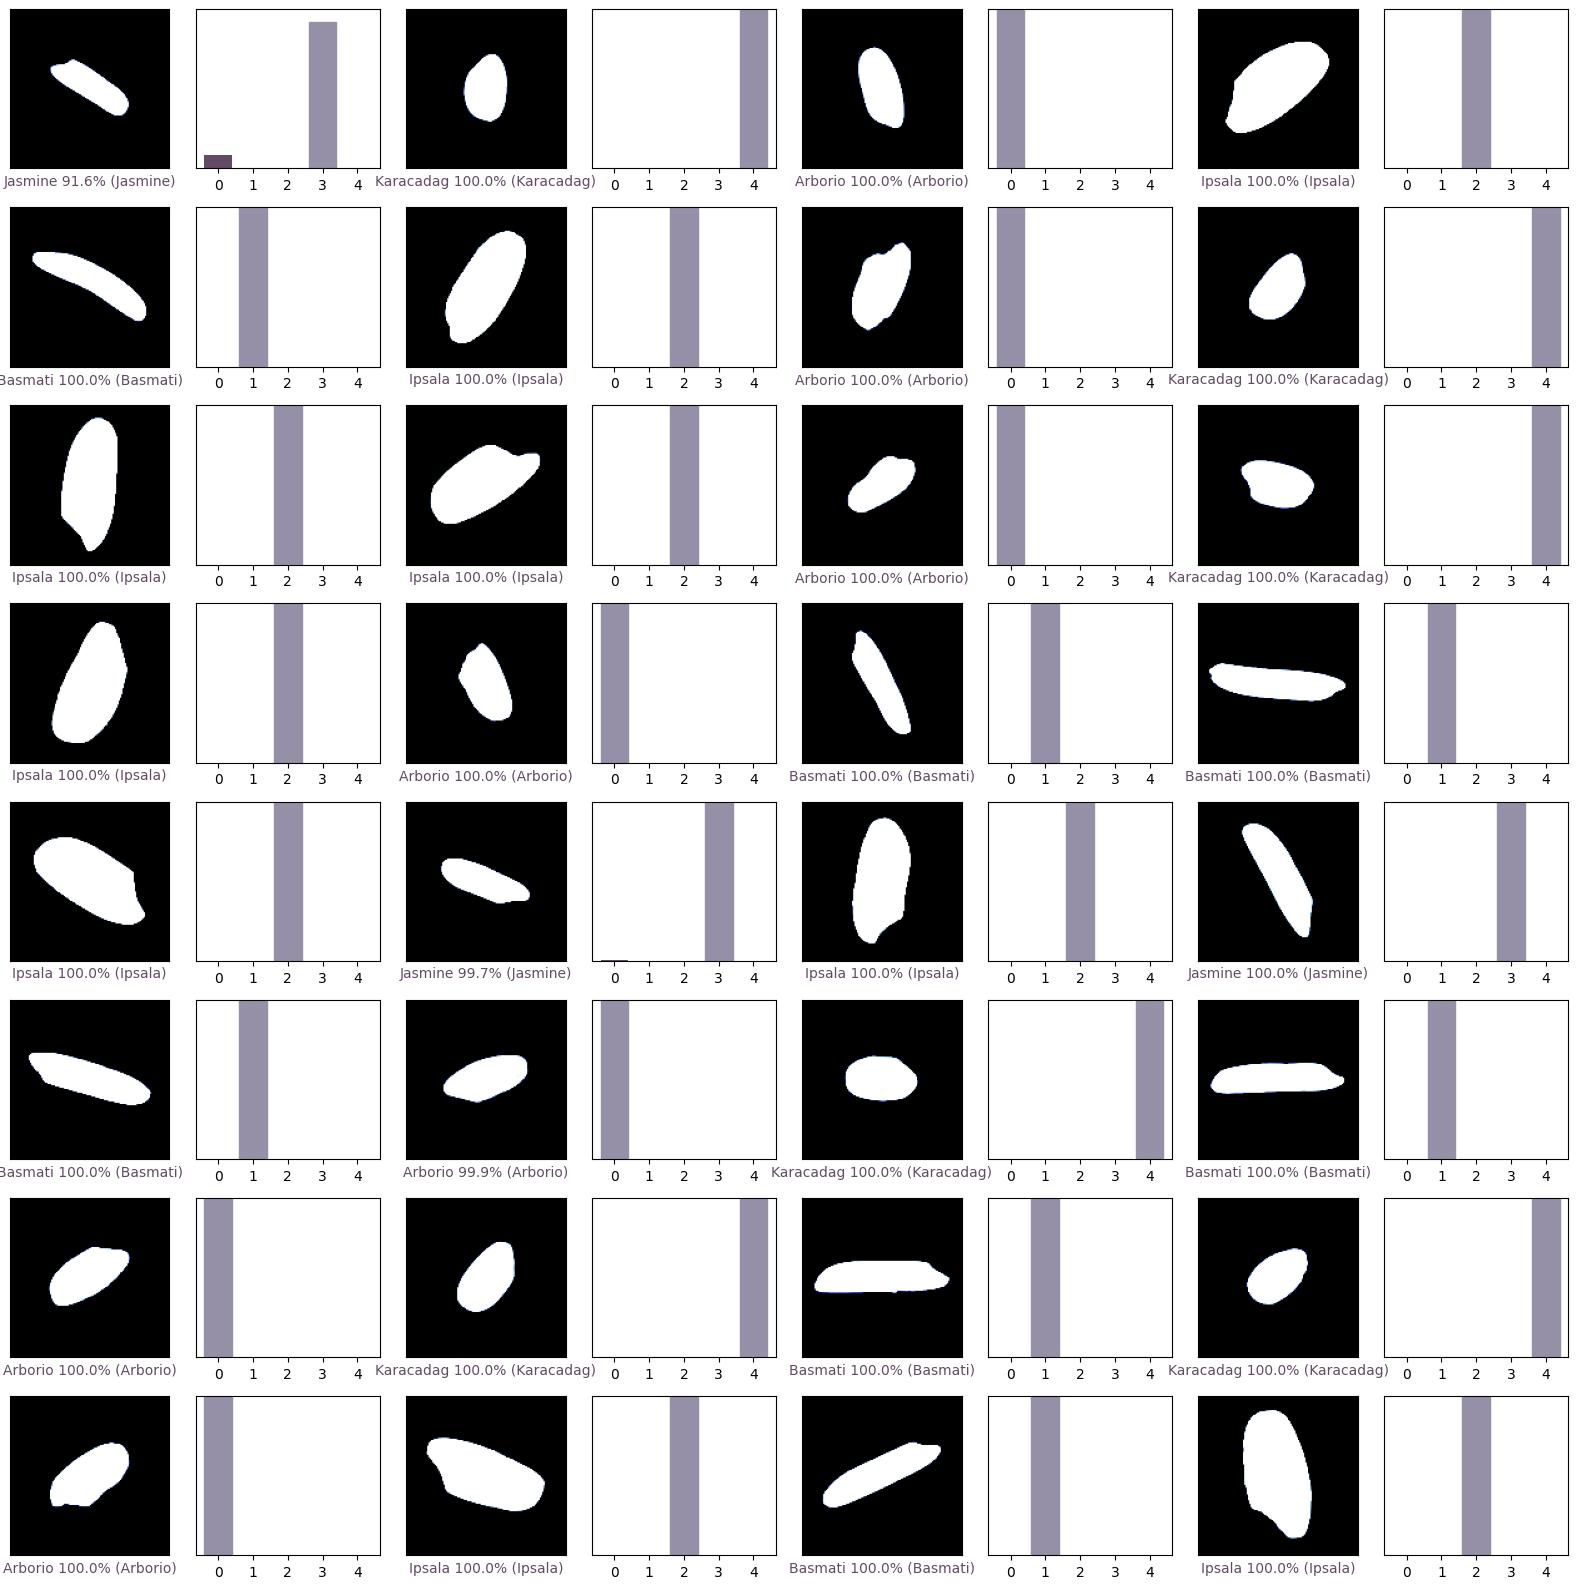

In [19]:
# Move model to CPU
cpu_model = model.cpu()

# Get 1 batch of test_loader
for images_batch, true_labels in test_loader:
    break

def plot_image(output, true_label, img, class_names):
    """
    Plot each image with its prediction and true label.
    Args:
        output (torch.Tensor): Prediction for the input image.
        true_label (torch.Tensor): True label for the input image.
        img (torch.Tensor): Input image.
        class_names (list): List of class names.
    """
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img_np = img.cpu().numpy().transpose((1, 2, 0))
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    
    output = torch.softmax(output, dim=1)  # Apply softmax to get probabilities
    predicted_value, predicted_label = torch.max(output, dim=1)
    predicted_label = predicted_label.cpu().item()
    true_label = true_label.cpu().item()
    
    if predicted_label == true_label:
        color = '#634b66'
    else:
        color = '#e5ffde'
    
    plt.xlabel(f"{class_names[predicted_label]} {100 * predicted_value.item():.1f}% ({class_names[true_label]})", color=color)

def plot_value_array(output, true_label):
    """
    Plot a bar plot of predictions.
    Args:
        output (torch.Tensor): Prediction array for an image.
        true_label (torch.Tensor): True label for the image.
    """
    output = torch.softmax(output, dim=1).squeeze()  # Apply softmax and remove singleton dimensions
    predicted_value, predicted_label = torch.max(output, dim=0)
    predicted_label = predicted_label.cpu().item()
    true_label = true_label.cpu().item()
    
    plt.grid(False)
    plt.xticks(range(len(output)))
    plt.yticks([])
    thisplot = plt.bar(range(len(output)), output.cpu().detach().numpy() * 100, color="#634b66")
    plt.ylim([0, 100])
    
    thisplot[predicted_label].set_color('#bbcbcb')
    thisplot[true_label].set_color('#9590a8')

def plot_model_result(outputs, test_labels, test_images, class_names, num_rows=8, num_cols=4):
    """
    Plot the first X test images, their predicted labels, and true labels.
    Args:
        outputs (list of torch.Tensor): All predictions for test images.
        test_labels (list of torch.Tensor): All true labels for test images.
        test_images (list of torch.Tensor): All test images.
        class_names (list): List of class names.
        num_rows (int): Number of rows in the grid.
        num_cols (int): Number of columns in the grid.
    """
    num_images = num_rows * num_cols
    plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
        plot_image(outputs[i], test_labels[i], test_images[i], class_names)
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
        plot_value_array(outputs[i], test_labels[i])
    plt.tight_layout()
    plt.show()

# Prepare outputs and labels
outputs = []
for img in images_batch:
    img = img.unsqueeze(0).cpu()  # Move to CPU
    with torch.no_grad():
        output = cpu_model(img)
    outputs.append(output.cpu())

# Plot model results
class_names = list(rice_variety_labels.values())  # rice_variety_labels contains the class names
plot_model_result(outputs, true_labels, images_batch, class_names)

In [20]:
model = model.to(dgpu)
y_true = []
y_pred = []
for images, labels in test_loader:
    images = images.to(dgpu)
    labels = labels.numpy()
    outputs = model(images)
    _, pred = torch.max(outputs.data, 1)
    pred = pred.detach().cpu().numpy()
    y_true = np.append(y_true, labels)
    y_pred = np.append(y_pred, pred)

In [21]:

# Assuming y_true and y_pred (numpy arrays or lists of labels) are available.

# --- 1. Define Class Names ---
# Assuming 'rice_variety_labels' is a dictionary mapping indices to names, 
# and has been converted to a list of names.
# Example structure: class_names = ['Basmati', 'Ipsala', 'Jasmine', 'Karacadag', 'Arborio']
class_names = list(rice_variety_labels.values()) 

# --- 2. Generate and Print Report ---
print("\n" + "="*70)
print("             DETAILED CLASSIFICATION REPORT")
print("="*70)

# Generate the classification report
# target_names provides the labels for each row in the report
report = classification_report(
    y_true, 
    y_pred, 
    target_names=class_names, 
    digits=4 # Increase precision for better visualization of high performance
)

# Print the report
print(report)
print("="*70)


             DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Arborio     0.9774    0.9996    0.9884      2250
     Basmati     0.9996    0.9973    0.9984      2250
      Ipsala     1.0000    0.9969    0.9984      2250
     Jasmine     0.9973    0.9902    0.9938      2250
   Karacadag     0.9996    0.9893    0.9944      2250

    accuracy                         0.9947     11250
   macro avg     0.9948    0.9947    0.9947     11250
weighted avg     0.9948    0.9947    0.9947     11250



# **Resulting Summary**

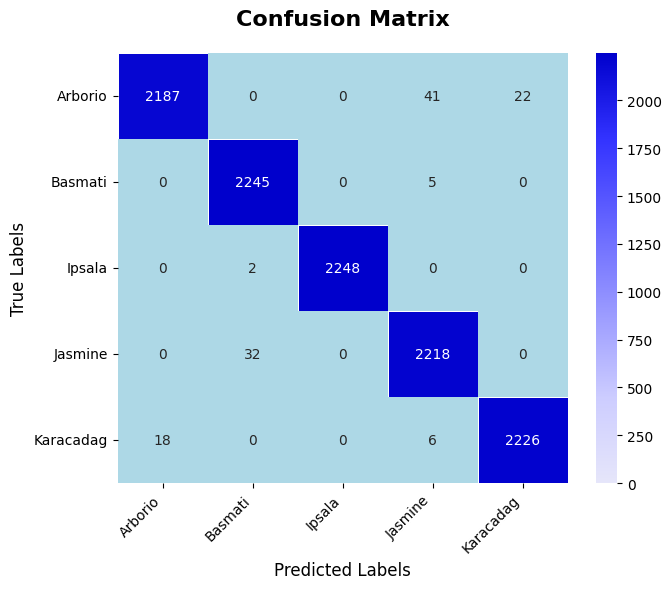

In [22]:


# --- 1. Data Definition ---

# Define the class names (labels for the axes)
class_names = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

# Define the confusion matrix data from the image (True Labels x Predicted Labels)
# Rows: True Labels, Columns: Predicted Labels
conf_matrix = np.array([
    [2187,    0,    0,   41,   22],
    [   0, 2245,    0,    5,    0],
    [   0,    2, 2248,    0,    0],
    [   0,   32,    0, 2218,    0],
    [  18,    0,    0,    6, 2226]
])

# --- 2. Custom Colormap Definition (Pale Purple to Blue) ---

# Define the colors for the gradient: from a very light purple to a deep blue
colors = ["#E6E6FA", "#CCCCFF", "#9999FF", "#6666FF", "#3333FF", "#0000CC"] # Pale Purple to Dark Blue
custom_cmap = LinearSegmentedColormap.from_list("my_purple_blue_cmap", colors, N=256)

# You could also use a seaborn palette like:
# custom_cmap = sns.light_palette("darkblue", as_cmap=True) 
# custom_cmap = sns.color_palette("light:blue", as_cmap=True)

# --- 3. Plotting Setup ---

plt.figure(figsize=(7, 6))

# Create the heatmap using Seaborn
sns.heatmap(
    conf_matrix,
    annot=True,          # Show the numerical data in each cell
    fmt='d',             # Format the numbers as integers
    cmap=custom_cmap,    # <--- USE THE CUSTOM PURPLE-BLUE COLORMAP
    cbar=True,           # Show the color bar/scale
    linewidths=.5,       # Add thin lines between cells
    linecolor='white',   # Use white lines for clean separation between cells
    xticklabels=class_names, 
    yticklabels=class_names
)

# --- 4. Custom Off-Diagonal Background (to emphasize non-diagonal cells) ---

ax = plt.gca()
for i in range(len(class_names)):
    for j in range(len(class_names)):
        # Apply a very light gray/white background to the off-diagonal cells
        if i != j:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='lightblue', lw=0)) # Or use '#F8F8F8' for a softer white

# --- 5. Final Styling ---

plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Labels', fontsize=12)
plt.xlabel('Predicted Labels', fontsize=12)

# Rotate x-axis labels for better fit and readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Display the plot
plt.tight_layout()
plt.show()